# Working notebook to have a quick look at results

This notebook allows to have a look at the results of a specific calculation. For good plotting, other notebooks are used!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time, os, sys, gc

import svgutils.transform as sg 

import scipy
from scipy.interpolate import RegularGridInterpolator

import h5py 

import class_energy as energy

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

## Functions for plotting, IO and time propagation

First: a function that allows quick plotting of wavefunctions

In [2]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

Second: a function o get the energies for one symmetry scan

In [3]:
def get_psi_properties(file_path, check_size, check_sym):
    h5_io_object = h_in.io_hdf5()
    file_list = [f for f in os.listdir(file_path) if check_size in f and check_sym in f]

    V_0_arr = np.zeros(len(file_list), dtype=complex)

    E_arr = np.zeros(len(file_list), dtype=complex)
    B_arr = np.zeros(len(file_list), dtype=complex)
    V_arr = np.zeros(len(file_list), dtype=complex)
    Tx_arr = np.zeros(len(file_list), dtype=complex)
    Ty_arr = np.zeros(len(file_list), dtype=complex)

    i = 0
    for file in file_list:
        psi, params = h5_io_object.get_psi(file_path+file)

        energy_object = energy.energy(params=params)

        E = energy_object.calc_energy(psi) # in form [E, E_T, E_B, E_V]
        Tx, Ty = energy_object.deriv_dE_dt(psi)

        E_arr[i] = E[0]
        B_arr[i] = E[2]
        V_arr[i] = E[3]
        Ty_arr[i] = Ty
        Tx_arr[i] = Tx

        V_0_arr[i] = params['V_0']

        i += 1

    index_sort = np.argsort(V_0_arr)

    V_0_arr = V_0_arr[index_sort]

    E_arr = E_arr[index_sort]
    B_arr = B_arr[index_sort]
    V_arr = V_arr[index_sort]
    Tx_arr = Tx_arr[index_sort]
    Ty_arr = Ty_arr[index_sort]

    return V_0_arr, E_arr, B_arr, V_arr, Tx_arr, Ty_arr

Third: Provided the sum and diff of tunneling rates, return $t_x$ and $t_y$

In [4]:
def get_tx_ty(sum, diff):
    '''  
    Return tx and ty tunneling rates
    '''
    tx = 0.5*(sum+diff)
    ty = 0.5*(sum-diff)
    return tx, ty

## Define Calculation Parameters

In [5]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-9}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

### Read the whole folder to see what files are there

In [6]:
sum_tx_ty = 200
diff_tx_ty = -150

B = 1.0 

Mx = 32
My = 4

tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty)

check_sym  = 'tx_'+str(tx)+'_ty_'+str(ty)
check_size = 'B_'+str(B)+'_Mx_'+str(Mx)+'_My_'+str(My)
file_path = 'results/phase_diagram/fdh/'

h5_io_object = h_in.io_hdf5()
file_list = [f for f in os.listdir(file_path) if check_size in f and check_sym in f]

V_0_list, E_arr, B_arr, V_arr, Tx_arr, Ty_arr = get_psi_properties(file_path, check_size, check_sym)

print('files: ', file_list)

print('\nB,tx,ty = ', B, tx, ty)
print('\nV_0: ', V_0_list)

files:  ['tx_25.0_ty_175.0_V0_170_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_205_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_45_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_195_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_125_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_10_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_250_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_240_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_135_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_185_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_215_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_55_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_160_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_5_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_75_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_235_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_285_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_140_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_260_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_V0_90_B_1.0_Mx_32_My_4.hfd5', 'tx_25.0_ty_175.0_

### Results of one calculation

{'n': 256, 'Mx': 32, 'Mx_display': 4, 'converge_new_lattice': 'no', 'My': 4, 'M': 128, 'My_display': 4, 'B': 1.0, 'tx': 25.0, 'ty': 175.0, 'V_0': 45.0, 'qx': 0, 'qy': 0, 'init_choice': 'ferro_domain_vertical_wall', 'external_wf_tag': ' ', 'excitation_no': 0, 'angle_pattern': [0, 0, 0, 0], 'V_0_pattern': [0, 0, 0, 0], 'n_states': 0, 'path_to_input_wavefunction': ' ', 'dt': 0.001, 'tol': 1e-10}
E = [-160.86244635+5.62658141e-17j  -24.19175133-1.85099923e-30j
    7.43400078+5.62658141e-17j -144.1046958 +0.00000000e+00j]
Tx = (-0.967487704831036-7.395570986446986e-32j)  Ty = (-2.6049780645017867e-05-1.2037062152420224e-35j)


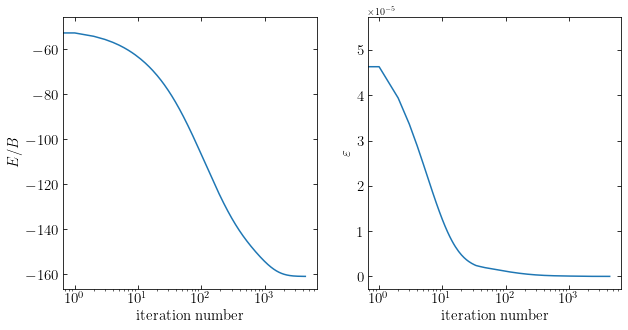

In [37]:
file = file_list[2]
psi, params = h5_io_object.get_psi(file_path+file)
e_evo, epsilon_evo = h5_io_object.get_evo_values(file_path+file)

energy_object = energy.energy(params=params)

E = energy_object.calc_energy(psi) # in form [E, E_T, E_B, E_V]
Tx, Ty = energy_object.deriv_dE_dt(psi)

print(params)
print('E =', E)
print('Tx =', Tx, ' Ty =', Ty)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].plot(e_evo/B)
axs[1].plot(epsilon_evo)

axs[0].set_xscale('log')

axs[1].set_xscale('log')
#axs[1].set_yscale('log')

axs[0].set_xlabel(r'iteration number', fontsize=font_size)
axs[0].set_ylabel(r'$E/B$', fontsize=font_size)

axs[1].set_xlabel(r'iteration number', fontsize=font_size)
axs[1].set_ylabel(r'$\varepsilon$', fontsize=font_size)

axs[0].tick_params(axis='x', direction='in', length=4, top=True, labelsize=font_size)
axs[0].tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)

axs[1].tick_params(axis='x', direction='in', length=4, top=True, labelsize=font_size)
axs[1].tick_params(axis='y', direction='in', length=4, right=True, labelsize=font_size)

axs[0].tick_params(which='minor', axis='y', direction='in', right=True)
axs[1].tick_params(which='minor', axis='y', direction='in', right=True)

### Results for scan over many potential points

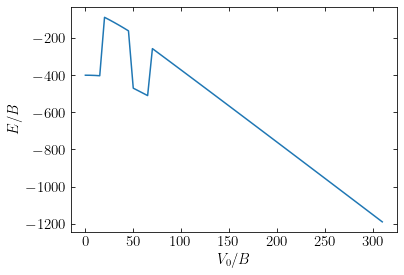

In [38]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

plt.plot(V_0_list.real, E_arr.real)

plt.xlabel(r'$V_0/B$', fontsize=font_size)
plt.ylabel(r'$E/B$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)